In [327]:
# Libraries
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import pickle
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from dotenv import load_dotenv
from supabase import create_client, Client
import os

In [328]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

MAKE = "Acura"
min_observations = 10

response = (
    supabase.table("bat_completed_auctions")
    .select("year, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status")
    .eq("make", MAKE)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .execute()
)
df = pd.DataFrame(response.data)

In [329]:
# Top Prices by model
prices = df[['model','sold_price']].groupby('model').mean().sort_values(by='sold_price',ascending=False)
print(prices)

                            sold_price
model                                 
NSX Zanardi Edition #51  277017.000000
NSX Type S               241238.142857
NSX Coupe 6-Speed        185000.000000
NSX-T 6-speed            167500.000000
NSX Zanardi Edition #06  154006.000000
...                                ...
Integra Type S                     NaN
NSX Targa                          NaN
RDX PMC Edition                    NaN
TL SH-AWD                          NaN
TSX Race Car                       NaN

[101 rows x 1 columns]


In [330]:
# Price by model
display_p=df[['model','year','sold_price']]

fig=px.box(display_p,x="model",y="sold_price")
fig.update_layout(title_text='Price vs Model',xaxis_title="Model",yaxis_title="Average Price")

In [331]:
# Filter to models with more than min_observations
counts=df['model'].value_counts()
frequent_models = counts[counts >= min_observations].index

# Filter the data to frequent models
df = df[df['model'].isin(frequent_models)]
popular_labels=frequent_models

colors=['lightslategray',]*len(popular_labels)
colors[0]='crimson'

fig=go.Figure(data=[go.Bar(x=counts[:25],y=popular_labels,marker_color=colors,orientation='h')])
fig.update_layout(title_text='Most represented Models in the Dataset',xaxis_title="Count",yaxis_title="Model")

In [332]:
#distribution of number of cars over the years
dic = {1970+i : sum(df['year']==1970+i) for i in range(55)}
x_dic = [1970 + i for i in range(55)]
y_dic = [dic[1970 + i] for i in range(55)]

# Plot
fig = go.Figure([go.Bar(x=x_dic, y=y_dic)])

fig.update_layout(title="Car year distribution",
                  xaxis_title="Year",
                  yaxis_title="Count Cars sold")


fig.show()

In [333]:
# Distribution of transmission
data_pie = df['transmission'].value_counts()

fig = go.Figure(data=[go.Pie(labels=data_pie.index, values=data_pie.tolist(), textinfo='label+percent',insidetextorientation='radial')])

fig.update_traces(hole=.3, hoverinfo="label+percent+name")

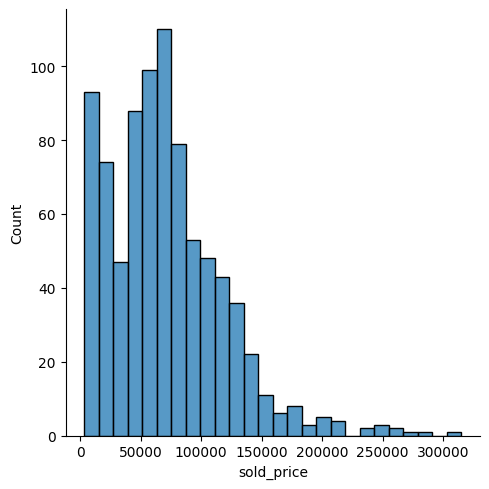

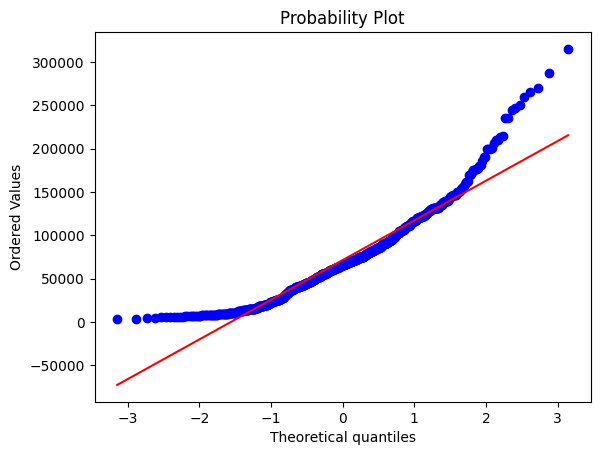

In [334]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])
df = df.dropna()

# Remove outliers
price_threshold = 1000000
df.drop(df[df['sold_price'] >= price_threshold].index,inplace=True)

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


array([[<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'mileage'}>],
       [<Axes: title={'center': 'sold_price'}>,
        <Axes: title={'center': 'bid_amount'}>]], dtype=object)

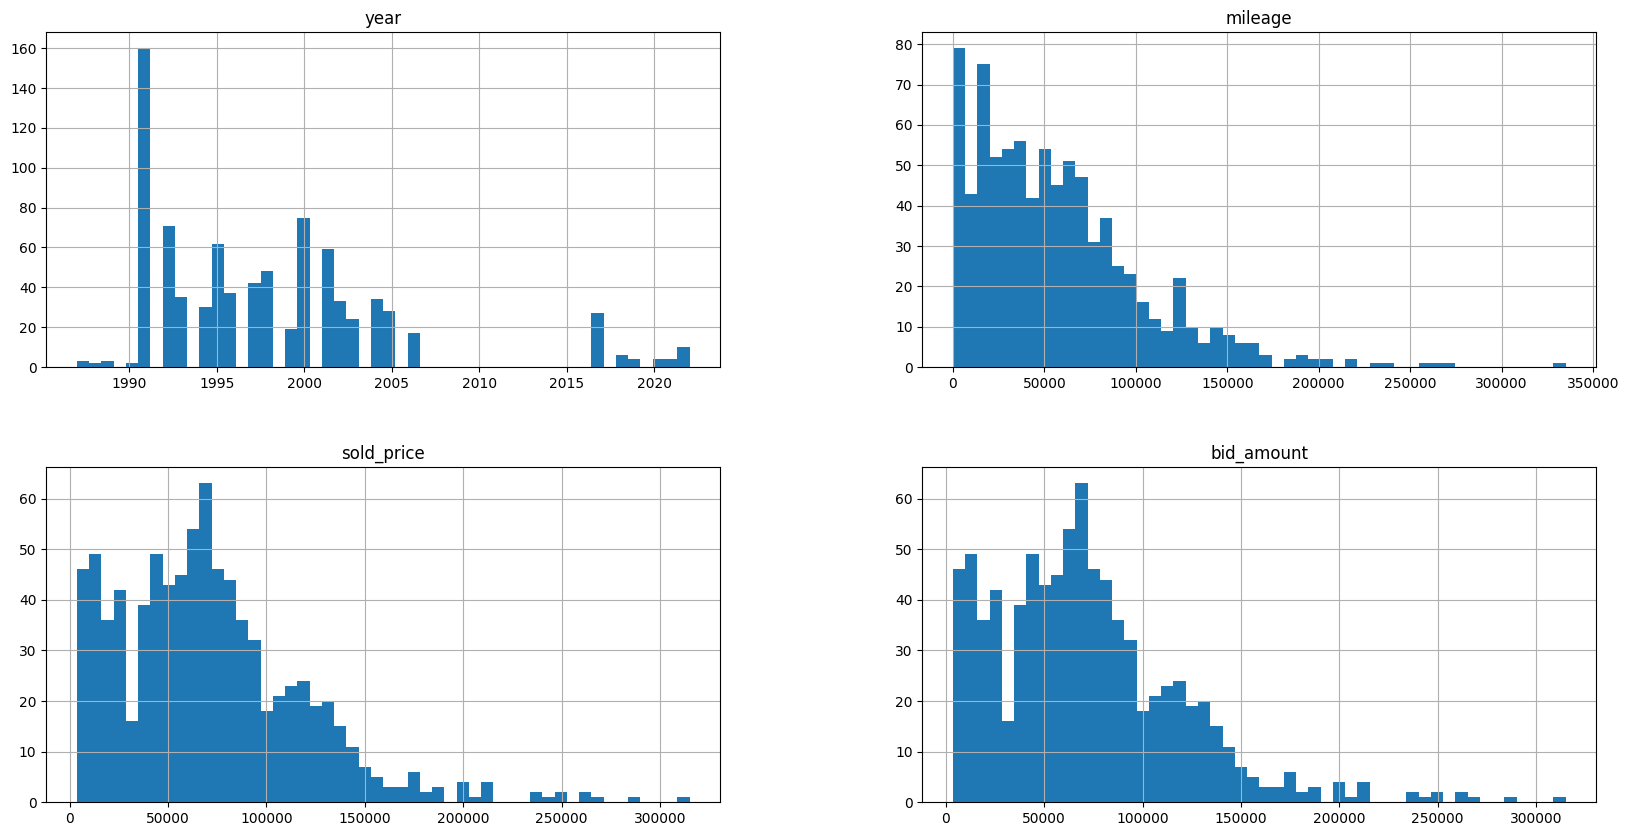

In [335]:
# Data distribution
df.hist(figsize=(20,10),bins = 50)

In [336]:
# Weight by recency
df['days_since_end'] = (pd.to_datetime(date.today()) - pd.to_datetime(df["end_date"])).dt.days
K = 1
T = 360
df['W'] = K*np.exp(-df['days_since_end']/T)


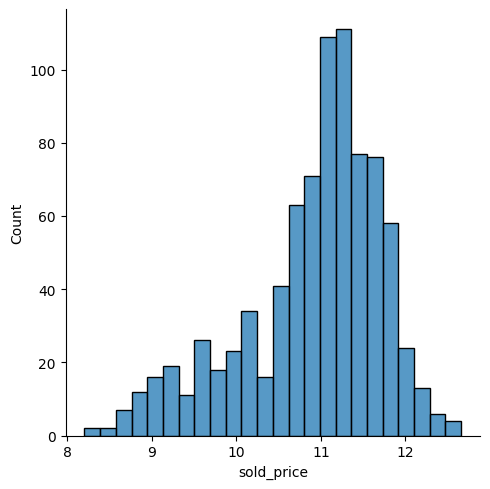

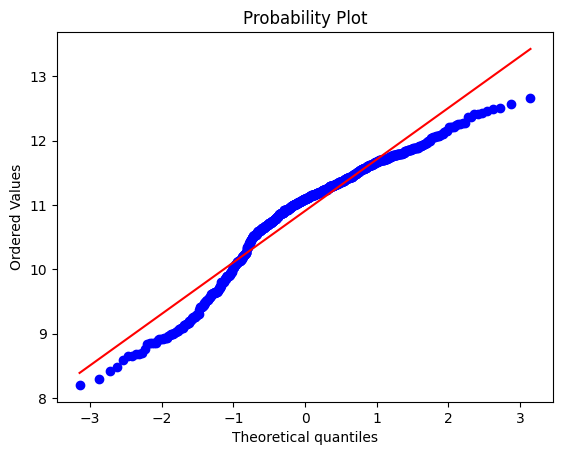

In [337]:
#Log transform sold_price & mileage
df['sold_price'] = np.log(df['sold_price'])
df['mileage'] = np.log1p(df['mileage'])

sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)

In [338]:
# Summarize transformed data
df.describe()

,year,mileage,sold_price,bid_amount,days_since_end,W
count,839.000000,839.000000,839.000000,839.000000,839.000000,839.000000
mean,1998.038141,10.459667,10.907631,71477.646007,1197.802145,0.149781
std,7.148007,1.348643,0.823775,47431.865380,753.129860,0.218530
min,1987.000000,0.000000,8.202482,3650.000000,8.000000,0.000096
25%,1992.000000,9.998843,10.556690,38435.000000,598.500000,0.009007
50%,1997.000000,10.778977,11.097410,66000.000000,1077.000000,0.050204
75%,2001.000000,11.298226,11.461632,95000.000000,1695.500000,0.189664
max,2022.000000,12.721889,12.660328,315000.000000,3330.000000,0.978023


In [339]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "days_since_end"],axis=1)
X

,year,model,mileage,normalized_color,transmission,W
25,1992,Integra GS 5-Speed,11.759793,Black,manual,0.132361
26,2000,Integra GS 5-Speed,10.933125,Black,manual,0.037399
27,1992,Integra GS 5-Speed,11.964007,Brown,manual,0.038774
28,1992,Integra GS 5-Speed,11.751950,Black,manual,0.056573
29,1992,Integra GS 5-Speed,11.767575,Black,manual,0.277883
...,...,...,...,...,...,...
1043,2005,RSX Type-S 6-Speed,10.341775,Black,automatic,0.003802
1044,2002,RSX Type-S 6-Speed,9.741027,Blue,manual,0.002358
1045,2004,RSX Type-S 6-Speed,8.366603,Silver,automatic,0.002237
1046,2006,RSX Type-S 6-Speed,10.668979,Gray,manual,0.025279


In [340]:
# Encode categorical features
Lbl_model = LabelEncoder()
Lbl_color = LabelEncoder()
Lbl_trans = LabelEncoder()

#df.make=Lbl.fit_transform(df.make)
X.model=Lbl_model.fit_transform(df.model)
print("Model Mapping:", dict(zip(Lbl_model.classes_, Lbl_model.transform(Lbl_model.classes_))))
X.normalized_color=Lbl_color.fit_transform(df.normalized_color)
print("Color Mapping:", dict(zip(Lbl_color.classes_, Lbl_color.transform(Lbl_color.classes_))))
X.transmission =Lbl_trans.fit_transform(df.transmission)
print("Trans Mapping:", dict(zip(Lbl_trans.classes_, Lbl_trans.transform(Lbl_trans.classes_))))
X

Model Mapping: {'Integra GS 5-Speed': 0, 'Integra GS-R': 1, 'Integra GS-R 5-Speed': 2, 'Integra LS 5-Speed': 3, 'Integra Type R': 4, 'Legend L Coupe': 5, 'NSX': 6, 'NSX 5-Speed': 7, 'NSX Type S': 8, 'NSX-T': 9, 'NSX-T 5-Speed': 10, 'NSX-T 6-Speed': 11, 'RSX Type-S': 12, 'RSX Type-S 6-Speed': 13}
Color Mapping: {'Black': 0, 'Blue': 1, 'Brown': 2, 'Gold': 3, 'Gray': 4, 'Green': 5, 'Orange': 6, 'Purple': 7, 'Red': 8, 'Silver': 9, 'Tan': 10, 'White': 11, 'Yellow': 12}
Trans Mapping: {'automatic': 0, 'manual': 1}


,year,model,mileage,normalized_color,transmission,W
25,1992,0,11.759793,0,1,0.132361
26,2000,0,10.933125,0,1,0.037399
27,1992,0,11.964007,2,1,0.038774
28,1992,0,11.751950,0,1,0.056573
29,1992,0,11.767575,0,1,0.277883
...,...,...,...,...,...,...
1043,2005,13,10.341775,0,0,0.003802
1044,2002,13,9.741027,1,1,0.002358
1045,2004,13,8.366603,9,0,0.002237
1046,2006,13,10.668979,4,1,0.025279


In [341]:
# Fit Model
# Features
# year	model	mileage	normalized_color	transmission

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle = True)

car_model_rf = RandomForestRegressor(n_estimators=300, random_state=33, monotonic_cst = [0,0,-1,0,0,0])
car_model_rf.fit(X_train,y_train, sample_weight=X_train['W'])
print('Random Forest Regressor Train Score is : ' ,  car_model_rf.score(X_train, y_train))
print('Random Forest Regressor Test Score is : ' , car_model_rf.score(X_test, y_test)) 

predicted_rf = pd.DataFrame(car_model_rf.predict(X_test), index=X_test.index, columns=['predicted_rf'])
car_model_rf.feature_importances_

#car_model_xgb = XGBRegressor(n_estimators=150, random_state=33)
#car_model_xgb.fit(X_train,y_train, sample_weight=X_train['W'])
#print('XGB Regressor Train Score is : ' ,  car_model_xgb.score(X_train, y_train))
#print('XGB Regressor Test Score is : ' , car_model_xgb.score(X_test, y_test)) 
#predicted_xgb = pd.DataFrame(car_model_xgb.predict(X_test), index=X_test.index, columns=['predicted_xgb'])


Random Forest Regressor Train Score is :  0.8767340990885085
Random Forest Regressor Test Score is :  0.8107616521639389


array([0.14140109, 0.50441056, 0.31703518, 0.00837358, 0.00414509,
       0.0246345 ])

In [342]:
# Inverse transform features
X_analysis = X_test.copy()
X_analysis.model = Lbl_model.inverse_transform(X_test.model)
X_analysis.normalized_color = Lbl_color.inverse_transform(X_test.normalized_color)
X_analysis.transmission = Lbl_trans.inverse_transform(X_test.transmission)
X_analysis

,year,model,mileage,normalized_color,transmission,W
371,2018,NSX,8.987322,Black,automatic,0.212838
1034,2004,RSX Type-S 6-Speed,10.085851,Black,manual,0.514845
161,2001,Integra Type R,10.373522,Yellow,manual,0.128378
149,2000,Integra Type R,10.736418,Yellow,manual,0.002978
981,2022,NSX Type S,3.713572,Black,automatic,0.109275
...,...,...,...,...,...,...
756,1995,NSX-T 5-Speed,6.398595,Green,automatic,0.003909
960,2002,NSX-T 6-Speed,9.105091,Red,automatic,0.000539
881,2002,NSX-T 6-Speed,7.937732,Silver,manual,0.086534
968,2002,NSX-T 6-Speed,10.799596,Yellow,manual,0.953875


In [343]:
# Analyze Resulst: Add target and predicted values
X_analysis = pd.merge(y_test, X_analysis, how='inner', left_index=True, right_index=True)
#X_analysis = pd.merge(X_analysis, predicted_xgb, how='inner', left_index=True, right_index=True)
#X_analysis.predicted_xgb = np.exp(X_analysis.predicted_xgb)

X_analysis = pd.merge(X_analysis, predicted_rf, how='inner', left_index=True, right_index=True)
X_analysis.sold_price = np.exp(X_analysis.sold_price)
X_analysis.predicted_rf = np.exp(X_analysis.predicted_rf)
X_analysis.mileage = np.exp(X_analysis.mileage) - 1
X_analysis

,sold_price,year,model,mileage,normalized_color,transmission,W,predicted_rf
371,121000.0,2018,NSX,8000.0,Black,automatic,0.212838,135529.395824
1034,18050.0,2004,RSX Type-S 6-Speed,24000.0,Black,manual,0.514845,41616.667321
161,44100.0,2001,Integra Type R,32000.0,Yellow,manual,0.128378,63310.840910
149,30750.0,2000,Integra Type R,46000.0,Yellow,manual,0.002978,45312.593006
981,270002.0,2022,NSX Type S,40.0,Black,automatic,0.109275,212700.216163
...,...,...,...,...,...,...,...,...
756,60000.0,1995,NSX-T 5-Speed,600.0,Green,automatic,0.003909,143944.049503
960,85000.0,2002,NSX-T 6-Speed,9000.0,Red,automatic,0.000539,150358.343879
881,103103.0,2002,NSX-T 6-Speed,2800.0,Silver,manual,0.086534,199848.096836
968,110900.0,2002,NSX-T 6-Speed,49000.0,Yellow,manual,0.953875,93697.353580


In [344]:
# Define price ranges
def getrange(Price):
    if (Price >= 0 and Price < 50000):
        return '0 - 50000'
    if (Price >= 50000 and Price < 100000):
        return '50000 - 100000'
    if (Price >= 100000 and Price < 150000):
        return '100000 - 150000'
    if (Price >= 150000 and Price < 200000):
        return '150000 - 200000'
    if (Price >= 200000 and Price < 250000):
        return '200000 - 250000'
    if (Price >= 250000 and Price < 300000):
        return '250000 - 300000'
    if (Price >= 300000 and Price < 350000):
        return '300000 - 350000'
    if (Price >= 350000):
        return 'Over 350000'
X_analysis['Price Range'] = X_analysis['sold_price'].apply(lambda x:getrange(x))

X_analysis['Price Range'].value_counts()

Price Range
50000 - 100000     70
0 - 50000          52
100000 - 150000    36
150000 - 200000     8
250000 - 300000     1
200000 - 250000     1
Name: count, dtype: int64

<Axes: xlabel='sold_price', ylabel='predicted_rf'>

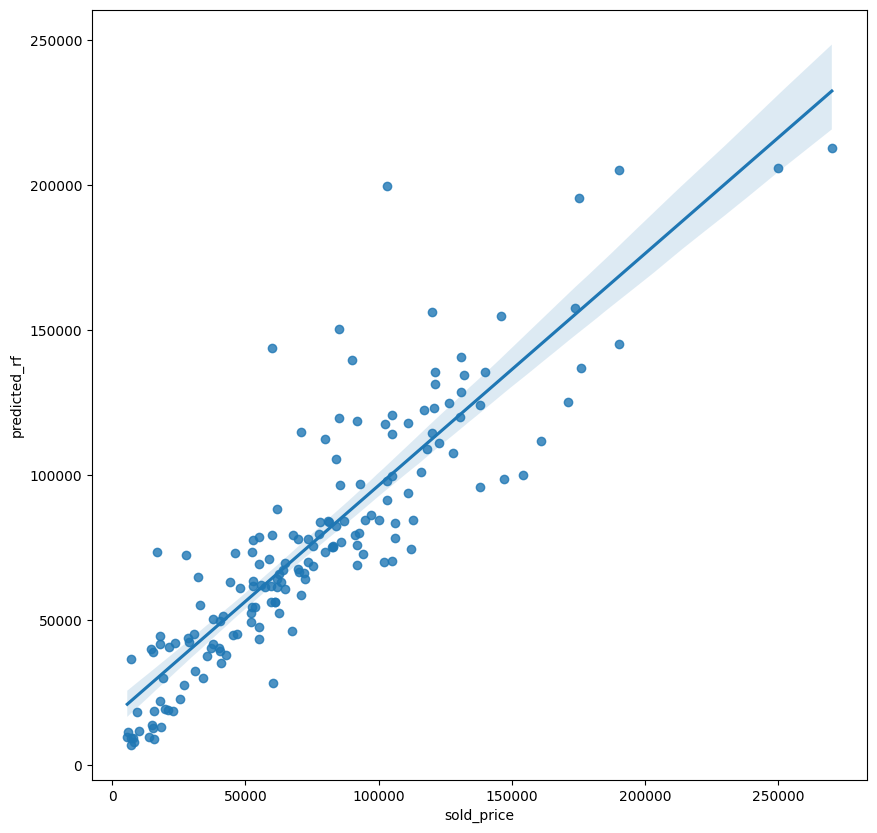

In [345]:
# Plot true vs predicted values scatter

plt.figure(figsize = (10, 10))
sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_rf)
#sns.regplot(x=X_analysis.sold_price, y=X_analysis.predicted_xgb)

In [346]:
# Save model
today_date = date.today().strftime('%Y-%m-%d')
model_filename = f'model_{MAKE}_{today_date}.pkl'
pickle.dump(car_model_rf, open(model_filename, 'wb'))

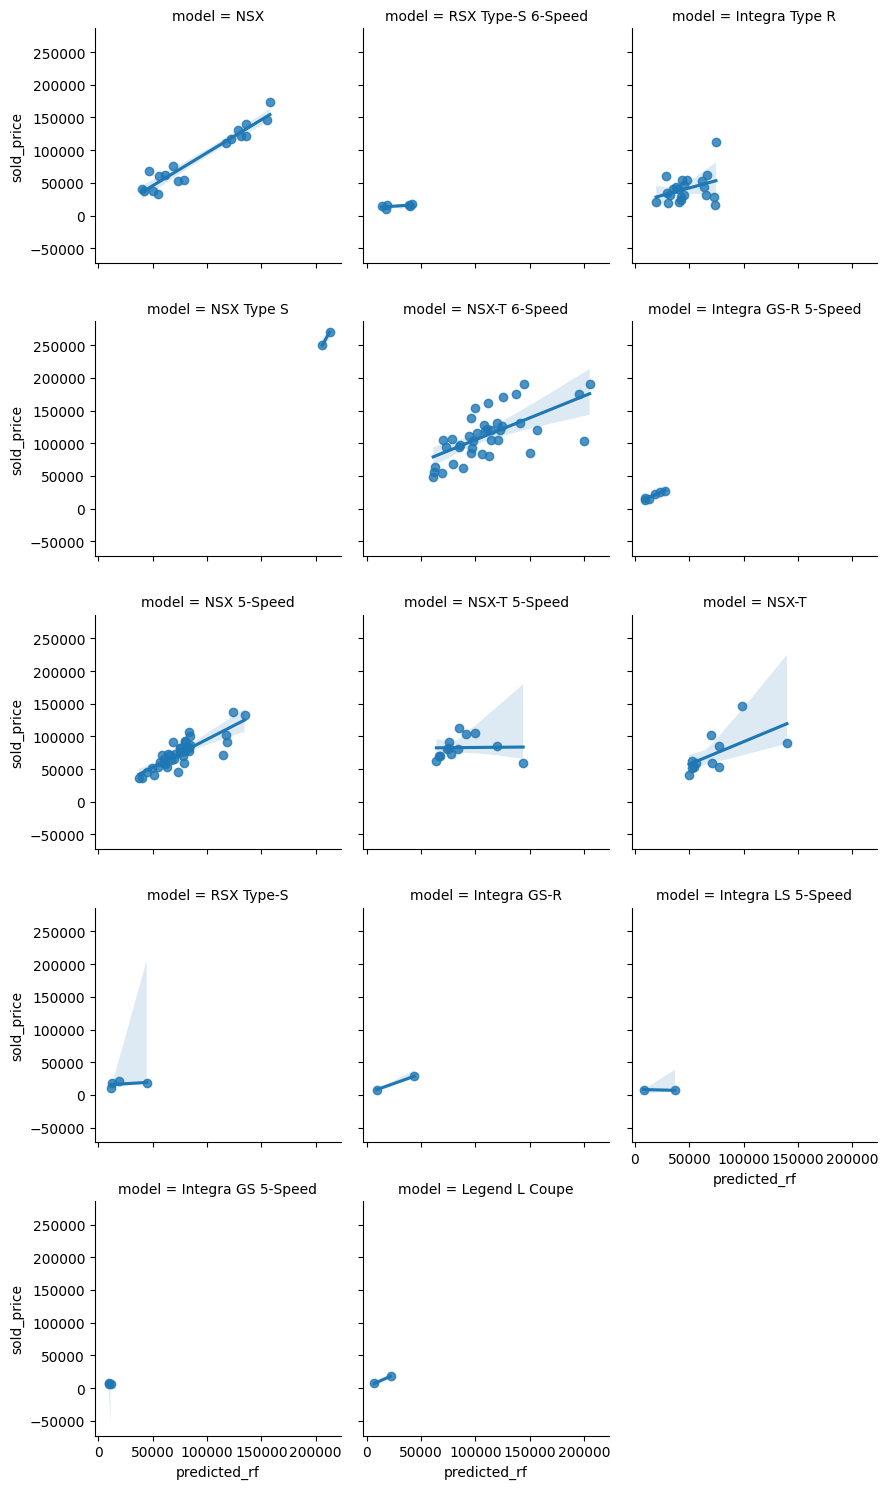

In [347]:
# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
#g.map(sns.regplot, "predicted_xgb", "sold_price")
g.map(sns.regplot, "predicted_rf", "sold_price")

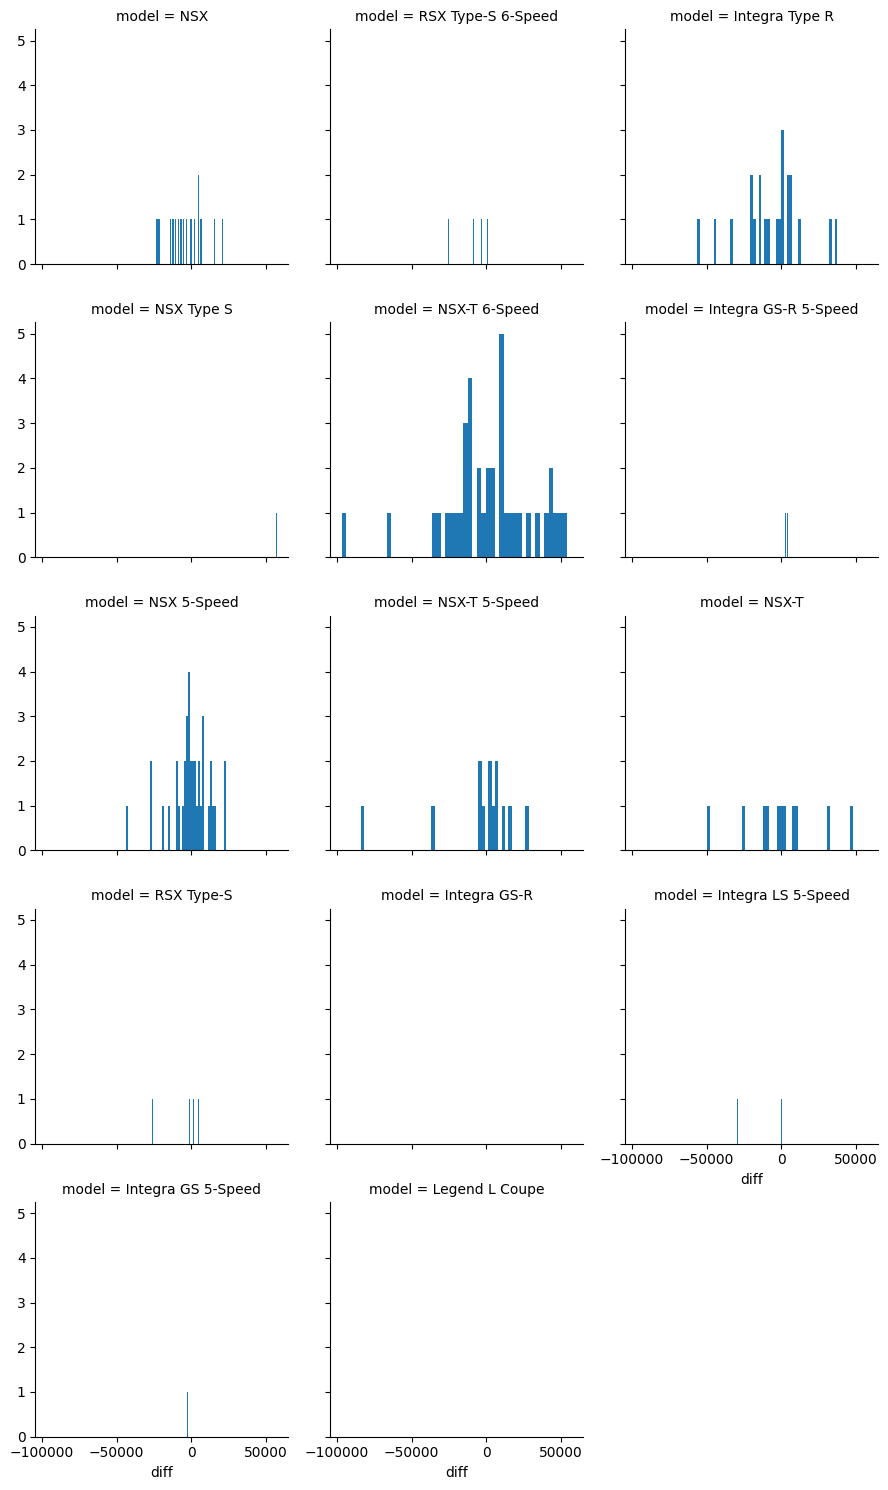

In [348]:
# Analyze Residuals by model
X_analysis['diff'] = X_analysis.sold_price - X_analysis.predicted_rf
g = sns.FacetGrid(X_analysis, col="model", col_wrap=3)

# Map scatter plots to the grid
g.map(plt.hist, "diff", bins = 50)


In [349]:
# Prediction function

def predict(year, model, mileage, color, transmission, carmodel, W):
    input_data = pd.DataFrame([[year, model, mileage, color, transmission, W]], 
                              columns=["year", "model", "mileage", "normalized_color", "transmission", "W"])
    input_data.model=Lbl_model.transform(input_data.model)
    input_data.normalized_color=Lbl_color.transform(input_data.normalized_color)
    input_data.transmission=Lbl_trans.transform(input_data.transmission)
    input_data.mileage = np.log1p(input_data.mileage)
    price_scaled = carmodel.predict(input_data)

    price = np.exp(price_scaled)
    
    return price[0].round(0)

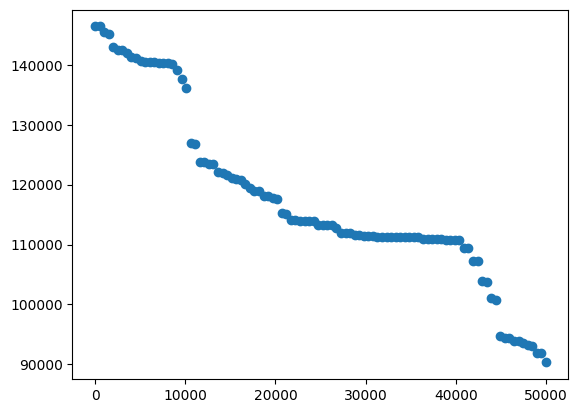

In [350]:
# Run a prediction for a car over a range of mileage
mileage_range = np.linspace(0, 50000, 100)

predictions = []
for mileage in mileage_range:
    prediction = predict(
        year = 2006,
        model = "NSX",
        mileage = mileage,
        color = "Silver",
        transmission = "manual",
        carmodel = car_model_rf,
        W = 1
    )
    predictions.append(prediction)

predictions = pd.DataFrame(predictions, columns=["predicted"])
mileage_range = pd.DataFrame(mileage_range, columns=["mileage"])
predictions = pd.merge(predictions, mileage_range, how='inner', left_index=True, right_index=True)
plt.scatter(predictions["mileage"], predictions["predicted"])